#**02_TERM FREQUENCY AND TFIDF**

Summary:


1.   Load Back Data and Merging
2.   Split *narco_data* into Schedules ([DEA](https://www.dea.gov/drug-information/drug-scheduling))
3.   Term Frequency
4.   TfIdf on Schedule 1 and Schedule 2
5.   TfIdf with respect to Time Periods

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Università/inforet_prj/')

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import pickle
import spacy
import string
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

In [ ]:
nlp = spacy.load("en_core_web_sm")

## **1. Load Back Data and Merging**

In [ ]:
narco_nlp = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_nlp_21set_nostop.csv", sep="|", names = ['spacy_nlp'], header=None)
narco_nlp

In [ ]:
narco_df = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_df.csv", sep="|")
narco_df

In [ ]:
narco_data = pd.concat([narco_df, narco_nlp], axis=1)

In [ ]:
def typo(text):
    cleaned_text = (
        text.replace('cannabi ','cannabis ')
        .replace('lysergic acid diethylamide', 'lsd')
        .replace('methylenedioxymethamphetamine', 'mdma')
        .replace('methylenedioxyamphetamine', 'mda')
        .replace(' meth ', ' methamphetamine ')
        .replace('meth[amphetamine]', 'methamphetamine')
        .replace('pseudo-ephedrine', 'pseudoephedrine')
        .replace(' homogenous ', ' 	homogeneous ')
        .replace('methamphetaminemanufacturing', 'methamphetamine manufacturing')
        .replace('controued', 'controlled')
        .replace('ciacetyl','diacetyl')
        .replace(' nar cotic', ' narcotic')
        .replace(' kilo ', ' kilogram ')
        .replace(' crosses ', ' cross ')
        .replace(' vick ', '')
        .replace(' fi ','')
        )
    return cleaned_text

In [ ]:
narco_data = narco_data.rename(columns= {'spacy_nlp':'lemmatized'})
narco_data.lemmatized

In [ ]:
narco_data['lemmatized'] = narco_data.lemmatized.progress_apply(lambda txt: typo(txt))

In [ ]:
del narco_df
del narco_nlp

In [ ]:
import gc
gc.collect()

### *1.1 Serialize narco_data*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "wb") as f:
    pickle.dump(narco_data, f)

---

## **2. Split *narco_data* into Schedules**

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "rb") as f:
    narco_data = pickle.load(f)

In [ ]:
schedule_1 = ["cannabis",  "marijuana",  "lsd", "heroin", 'methaqualone', "ecstasy", "peyote", "mescaline", "mda", "mdma"] #https://www.dea.gov/drug-information/drug-scheduling
schedule_2 = ["cocaine", "methamphetamine", "hydromorphone", "dilaudid", "meperidine", "demerol", "oxycodone", "dexedrine", "fentanyl", "ritalin", "methadone", "amphetamine", "phencyclidine", "pseudoephedrine", "ephedrine", "opium", "dilaudid", "preludin"]
schedule_3 = ["ketamine", "anabolic" , "steroids",  "testosterone", "ketamine"]
schedule_4 = ["modafinil", "provigil", "adderall", "methylphenidate", "memantine", "axura", "soma", "xanax", "darvon", "darvocet", "valium", "ativan", "talwin", "ambien", "tramadol",  "ethclorvynol"]
schedule_5 = ["phenylpropanolamine", "lomotil", "motofen", "lyrica", "parepectolin", "tetracaine"]

In [ ]:
conditions = [
    (narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5)))
    ]

# create a list of the values we want to assign for each condition
values = ['narco_1', 'narco_2', 'narco_3', 'narco_4']

# create a new column and use np.select to assign values to it using our lists as arguments
narco_data['schedule'] = np.select(conditions, values)

# display updated DataFrame
narco_data.head()

In [ ]:
narco_sch = narco_data.loc[:, ["schedule", "lemmatized", "year"]]

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_sch.pkl", "wb") as f:
    pickle.dump(narco_sch, f)

In [ ]:
# NARCO SCHEDULE MERGE
# Merge in one row all the opinions in the same schedule.
# We obtain narco_schedule with shape 5,2:
#   _0 (miscellaneous), narco_1, narco_2, narco_3, narco_4;
#   _schedule label and lemmatized corpora.

narco_schedule = narco_sch.groupby('schedule', as_index=False).agg({'lemmatized' : ' '.join}) 

### *2.1 Serialize narco_schedule*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "wb") as f:
    pickle.dump(narco_schedule, f)

---

## **3. Term Frequency**

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "rb") as f:
  narco_schedule = pickle.load(f)

In [ ]:
# Divide into schedules
narco_schedule_1 = narco_schedule.loc[narco_schedule['schedule']=="narco_1"] # 1421     
narco_schedule_2 = narco_schedule.loc[narco_schedule['schedule']=="narco_2"] # 2287   
#narco_schedule_3 # 1
#narco_schedule_4 # 6

In [ ]:
nar = narco_schedule[(narco_schedule.schedule == 'narco_1') | (narco_schedule.schedule =='narco_2')]

In [ ]:
vectorizer = CountVectorizer()
vector_narco = vectorizer.fit_transform(nar['lemmatized'])

words_list = vectorizer.get_feature_names()
count_list = vector_narco.toarray().sum(axis=0)

w = dict(zip(words_list, count_list))
w = {k: v for k, v in sorted(w.items(), key=lambda item: item[1], reverse=True)}

mcw = pd.DataFrame.from_dict(w, orient='index').reset_index()
mcw.columns = ["words_tot", "abs_freq"]

mcw["rel_freq"] = mcw.progress_apply(lambda x: np.round(x.abs_freq / mcw.abs_freq.sum(), 3), axis=1)

mcw[:10]

100%|██████████| 22660/22660 [00:02<00:00, 7669.77it/s]


,words_tot,abs_freq,rel_freq
0,defendant,184390,0.043
1,trial,70525,0.016
2,evidence,47484,0.011
3,testify,32590,0.008
4,find,30813,0.007
5,officer,28370,0.007
6,police,26679,0.006
7,testimony,23345,0.005
8,state,22919,0.005
9,jury,22180,0.005


In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(narco_schedule_1['lemmatized'])
words_list_1 = vectorizer.get_feature_names()
count_list_1 = X.toarray().sum(axis=0)
w_1 = dict(zip(words_list_1, count_list_1))
w_1 = {k: v for k, v in sorted(w_1.items(), key=lambda item: item[1], reverse=True)}
mcw_1 = pd.DataFrame.from_dict(w_1, orient='index').reset_index()
mcw_1.columns = ["words_1", "abs_freq"]
mcw_1["rel_freq"] = mcw_1.progress_apply(lambda x: np.round(x.abs_freq / mcw_1.abs_freq.sum(), 3), axis=1)
mcw_1["log_freq"] = mcw_1.progress_apply(lambda x: np.round(1+(math.log(x.abs_freq,5)), 3), axis=1)
mcw_1["augm_freq"] = mcw_1.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw_1.abs_freq.max()), 3), axis=1)
#
Y = vectorizer.fit_transform(narco_schedule_2['lemmatized'])
words_list_2 = vectorizer.get_feature_names()
count_list_2 = Y.toarray().sum(axis=0)
w_2 = dict(zip(words_list_2, count_list_2))
w_2 = {k: v for k, v in sorted(w_2.items(), key=lambda item: item[1], reverse=True)}
mcw_2 = pd.DataFrame.from_dict(w_2, orient='index').reset_index()
mcw_2.columns = ["words_2", "abs_freq"]
mcw_2["rel_freq"] = mcw_2.progress_apply(lambda x: np.round(x.abs_freq / mcw_2.abs_freq.sum(), 3), axis=1)
mcw_2["log_freq"] = mcw_2.progress_apply(lambda x: np.round(1+(math.log(x.abs_freq,5)), 3), axis=1)
mcw_2["augm_freq"] = mcw_2.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw_2.abs_freq.max()), 3), axis=1)

In [ ]:
mcw_1_2_concat = pd.concat([mcw_1[:10],mcw_2[:10]], axis=1)
mcw_1_2_concat # WORDS = tinfou, mitte, wtappe

,words_1,abs_freq,rel_freq,log_freq,augm_freq,words_2,abs_freq,rel_freq,log_freq,augm_freq
0,defendant,64578,0.042,7.882,1.000,defendant,119812,0.044,8.266,1.000
1,trial,24111,0.016,7.270,0.687,trial,46414,0.017,7.676,0.694
2,evidence,16567,0.011,7.036,0.628,evidence,30917,0.011,7.424,0.629
3,testify,11648,0.008,6.817,0.590,testify,20942,0.008,7.182,0.587
4,officer,11531,0.007,6.811,0.589,find,19669,0.007,7.143,0.582
5,find,11144,0.007,6.790,0.586,police,16901,0.006,7.049,0.571
6,police,9778,0.006,6.709,0.576,officer,16839,0.006,7.046,0.570
7,testimony,8980,0.006,6.656,0.570,jury,15039,0.005,6.976,0.563
8,search,8694,0.006,6.636,0.567,state,15021,0.005,6.976,0.563
9,arrest,7955,0.005,6.581,0.562,testimony,14365,0.005,6.948,0.560


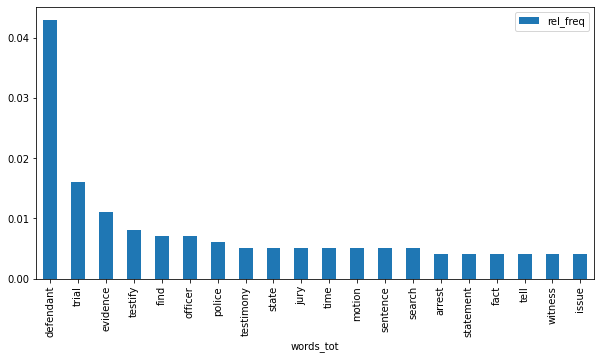

In [ ]:
mcw[:20].plot(x="words_tot", y="rel_freq", kind="bar", figsize=(10,5)) 
plt.show()

In [ ]:
mcw["augm_freq"] = mcw.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw.abs_freq.max()), 3), axis=1)

Text(0, 0.5, 'Augemnted Frequency')

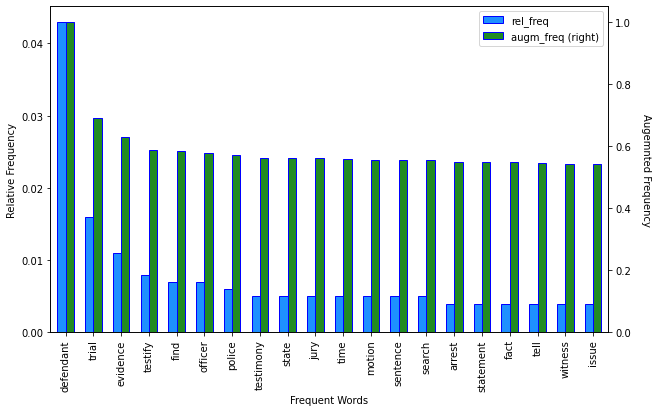

In [ ]:
mcw_freqs = mcw[['words_tot','rel_freq','augm_freq']]
ax = mcw_freqs[:20].plot(kind='bar', x = 'words_tot', secondary_y = 'augm_freq', color={"rel_freq": "dodgerblue", "augm_freq": "forestgreen"}, edgecolor='blue', figsize=(10,6), width= 0.6)

ax.set_xlabel("Frequent Words")
ax.set_ylabel("Relative Frequency")
plt.ylabel('Augemnted Frequency', rotation=-90, labelpad=20)

---

## **4. TfIdf on Schedule 1 and Schedule 2**

In [ ]:
def sort_matrr(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def top_words_tfidf(names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [ ]:
nar = narco_schedule[(narco_schedule.schedule == 'narco_1') | (narco_schedule.schedule =='narco_2')]

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(nar['lemmatized'])
tfidf_1 = tfidf_vectorizer.transform(narco_schedule_1['lemmatized'])
tfidf_2 = tfidf_vectorizer.transform(narco_schedule_2['lemmatized'])

In [ ]:
df_tfidf_1 = pd.DataFrame(zip(tfidf_vectorizer.get_feature_names(), tfidf_1.toarray()[0]), columns=["word", "value"]).sort_values("value", ascending=False).reset_index(drop=True)

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/df_tfidf_1.pkl", "wb") as f:
    pickle.dump(df_tfidf_1, f)

In [ ]:
df_tfidf_2 = pd.DataFrame(zip(tfidf_vectorizer.get_feature_names(), tfidf_2.toarray()[0]), columns=['word', 'value']).sort_values('value', ascending=False).reset_index(drop=True)

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/df_tfidf_2.pkl", "wb") as f:
    pickle.dump(df_tfidf_2, f)

In [ ]:
def find_tfidf(df, term, value=False):
    row = df.loc[df.word == term]

    if row.shape[0] == 0:
        return term +' not in vocabulary'
    
    if value:
        return row.index.values[0], term, row.value.values[0]
    
    return row.index[0], term

In [ ]:
find_tfidf(df_tfidf_1, 'narcotic', True)

(46, 'narcotic', 0.04509421043179443)

In [ ]:
def df_tfidf(df_1, df_2, n_min, n_max):
    aa = df_1[n_min : n_max]
    bb = df_2[n_min : n_max]
    df = pd.concat([aa, bb], axis=1) 
    return df

In [ ]:
df_tfidf(df_tfidf_1, df_tfidf_2, 0, 5)

,word,value,word,value
0,defendant,0.712003,defendant,0.726070
1,trial,0.265835,trial,0.281272
2,evidence,0.182659,evidence,0.187359
3,testify,0.128425,testify,0.126910
4,officer,0.127135,find,0.119196


----

## **5. TfIdf with respect to Time Periods**

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_sch.pkl", "rb") as f:
    narco_sch = pickle.load(f)

In [ ]:
narco_sch = narco_sch.loc[(narco_sch.schedule == 'narco_1') | (narco_sch.schedule=='narco_2')]

In [ ]:
narco_sch.loc[(narco_sch["year"] >= 1950) & (narco_sch["year"] <= 1959), 'year'] = 50 # 25
narco_sch.loc[(narco_sch["year"] >= 1960) & (narco_sch["year"] <= 1969), 'year'] = 60 # 211
narco_sch.loc[(narco_sch["year"] >= 1970) & (narco_sch["year"] <= 1979), 'year'] = 70 # 611
narco_sch.loc[(narco_sch["year"] >= 1980) & (narco_sch["year"] <= 1989), 'year'] = 80 # 769
narco_sch.loc[(narco_sch["year"] >= 1990) & (narco_sch["year"] <= 1999), 'year'] = 90 # 1124
narco_sch.loc[(narco_sch["year"] >= 2000) & (narco_sch["year"] <= 2009), 'year'] = 10 # 868

In [ ]:
narco_sch.loc[narco_sch["year"] == 50, 'year'] = '50s' 
narco_sch.loc[narco_sch["year"] == 60, 'year'] = '60s' 
narco_sch.loc[narco_sch["year"] == 70, 'year'] = '70s' 
narco_sch.loc[narco_sch["year"] == 80, 'year'] = '80s' 
narco_sch.loc[narco_sch["year"] == 90, 'year'] = '90s'
narco_sch.loc[narco_sch["year"] == 10, 'year'] = '00s'

In [ ]:
narco_sch.drop(narco_sch.loc[(narco_sch["year"] != '50s' ) & (narco_sch["year"] != '60s') & (narco_sch["year"] != '70s') & (narco_sch["year"] != '80s') & (narco_sch["year"] != '90s') & (narco_sch["year"] != '00s')].index, inplace=True)

In [ ]:
narco_time = narco_sch.groupby('year', as_index=False).agg({'lemmatized' : ' '.join})  

In [ ]:
narco_time = narco_time.reindex([1,2,3,4,5,0])

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_time.pkl", "wb") as f:
    pickle.dump(narco_time, f)

---

In [ ]:
narco_50s = narco_time.loc[narco_time['year']=="50s"]
narco_60s = narco_time.loc[narco_time['year']=="60s"] 
narco_70s = narco_time.loc[narco_time['year']=="70s"]
narco_80s = narco_time.loc[narco_time['year']=="80s"]
narco_90s = narco_time.loc[narco_time['year']=="90s"]
narco_00s = narco_time.loc[narco_time['year']=="00s"]

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(narco_time['lemmatized'])
tfidf_50_59 = tfidf_vectorizer.transform(narco_50s['lemmatized'])
tfidf_60_69 = tfidf_vectorizer.transform(narco_60s['lemmatized'])
tfidf_70_79 = tfidf_vectorizer.transform(narco_70s['lemmatized'])
tfidf_80_89 = tfidf_vectorizer.transform(narco_80s['lemmatized'])
tfidf_90_99 = tfidf_vectorizer.transform(narco_90s['lemmatized'])
tfidf_00_09 = tfidf_vectorizer.transform(narco_00s['lemmatized'])

In [ ]:
df_tfidf_50s = pd.DataFrame(zip(tfidf_vectorizer.get_feature_names(), tfidf_50_59.toarray()[0]), columns=["word", "value"]).sort_values("value", ascending=False).reset_index(drop=True)

In [ ]:
df_tfidf_60s = pd.DataFrame(zip(tfidf_vectorizer.get_feature_names(), tfidf_60_69.toarray()[0]), columns=["word", "value"]).sort_values("value", ascending=False).reset_index(drop=True)

In [ ]:
df_tfidf_70s = pd.DataFrame(zip(tfidf_vectorizer.get_feature_names(), tfidf_70_79.toarray()[0]), columns=["word", "value"]).sort_values("value", ascending=False).reset_index(drop=True)

In [ ]:
df_tfidf_80s = pd.DataFrame(zip(tfidf_vectorizer.get_feature_names(), tfidf_80_89.toarray()[0]), columns=["word", "value"]).sort_values("value", ascending=False).reset_index(drop=True)

In [ ]:
df_tfidf_90s = pd.DataFrame(zip(tfidf_vectorizer.get_feature_names(), tfidf_90_99.toarray()[0]), columns=["word", "value"]).sort_values("value", ascending=False).reset_index(drop=True)

In [ ]:
df_tfidf_00s = pd.DataFrame(zip(tfidf_vectorizer.get_feature_names(), tfidf_00_09.toarray()[0]), columns=["word", "value"]).sort_values("value", ascending=False).reset_index(drop=True)

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/df_tfidf_50s.pkl", "wb") as f:
    pickle.dump(df_tfidf_50s, f)

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/df_tfidf_60s.pkl", "wb") as f:
    pickle.dump(df_tfidf_60s, f)

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/df_tfidf_70s.pkl", "wb") as f:
    pickle.dump(df_tfidf_70s, f)

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/df_tfidf_80s.pkl", "wb") as f:
    pickle.dump(df_tfidf_80s, f)

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/df_tfidf_90s.pkl", "wb") as f:
    pickle.dump(df_tfidf_90s, f)

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/df_tfidf_00s.pkl", "wb") as f:
    pickle.dump(df_tfidf_00s, f)